In [232]:
# General
import pickle
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats
import itertools
from pandas.plotting import register_matplotlib_converters
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer, make_column_selector

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import trange

# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
warnings.filterwarnings('ignore')

In [316]:
# Load data, sort on zip and date and set index to datetime
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f: df = pickle.load(f)
df.sort_values(['census_cbsa_geoid', 'census_zcta5_geoid', 'date'], inplace = True)

In [127]:
df.columns

Index(['date', 'census_cbsa_geoid', 'census_zcta5_geoid', 'sfr_rental_index',
       'sfr_price_index', 'coef', 'nounits', 'occupied_units', 'mfr_occ',
       'mfr_mean_occ_index', 'mfr_mean_rent', 'mfr_mean_rent_index', 'month',
       'cos_month', 'sin_month', 'sfr_rental_delta', 'us_zip', 'population',
       'student_population_fraction', 'netflow_estimated', 'inflow_estimated',
       'outflow_estimated', 'cumulative_netflow_estimated',
       'median_income_inflow', 'median_income', 'median_income_difference',
       'median_age_inflow', 'median_age', 'median_age_difference',
       'inflow_index', 'outflow_index', 'netflow_index', 'income_inflow_index',
       'income_diff_index', 'age_inflow_index', 'age_inflow_diff_index'],
      dtype='object')

In [317]:
# subset for time frame that includes MFR data (Jan 2015 - June 2023)
df = df.loc[(df.date >= '2015-01-01') & (df.date <= '2023-06-01')]

In [318]:
# drop incomplete zips
drops = df.loc[df.mfr_occ.isna()].census_zcta5_geoid.unique().tolist()
df.drop(df.loc[df['census_zcta5_geoid'].isin(drops)].index, inplace=True)

In [319]:
# Translate all index columns into delta
df['offset_price_index'] = df['sfr_price_index'].shift(periods = 1)
df.dropna(inplace=True)
df['sfr_price_delta'] = df['sfr_price_index'] - df['offset_price_index']

df['offset_mfrrent_index'] = df['mfr_mean_rent_index'].shift(periods = 1)
df.dropna(inplace=True)
df['mfr_rent_delta'] = df['mfr_mean_rent_index'] - df['offset_mfrrent_index']

df['offset_mfrocc_index'] = df['mfr_mean_occ_index'].shift(periods = 1)
df.dropna(inplace=True)
df['mfr_occ_delta'] = df['mfr_mean_occ_index'] - df['offset_mfrocc_index']

In [320]:
# Keep only desired columns
df = df[['date', 'census_zcta5_geoid', 'sfr_rental_delta', 'sfr_price_delta', 
         'mfr_rent_delta', 'mfr_occ_delta', 'cos_month', 'sin_month']]
df

,date,census_zcta5_geoid,sfr_rental_delta,sfr_price_delta,mfr_rent_delta,mfr_occ_delta,cos_month,sin_month
109,2019-02-01,30002,0.5569,0.2339,0.4898,0.0323,0.5000,0.8660
110,2019-03-01,30002,0.6948,1.3213,1.2114,-0.1921,0.0000,1.0000
111,2019-04-01,30002,0.8489,0.2247,0.5009,-0.4165,-0.5000,0.8660
112,2019-05-01,30002,0.6759,0.6222,0.5009,-0.2884,-0.8660,0.5000
113,2019-06-01,30002,0.5433,0.9363,0.5140,-0.6174,-1.0000,0.0000
...,...,...,...,...,...,...,...,...
36073,2023-02-01,44333,0.8291,-1.3466,1.7447,0.0000,0.5000,0.8660
36074,2023-03-01,44333,0.6817,0.1833,0.8363,-0.2888,0.0000,1.0000
36075,2023-04-01,44333,0.9218,1.0300,0.2950,0.0000,-0.5000,0.8660
36076,2023-05-01,44333,1.3360,1.8028,-0.0658,-0.2865,-0.8660,0.5000


In [321]:
# Filter to one zip
data = df[df['census_zcta5_geoid'] == '30002']

In [322]:
# Keep track of min / max values per delta columns to scale to (-1, 1)
# Then scale it back to original values after prediction
# Do min/max only on training dataset otherwise leaking info

sfr_delta_min = data['sfr_rental_delta'].min() 
sfr_delta_max = data['sfr_rental_delta'].max()
print('sfr delta min: ', sfr_delta_min)
print('sfr delta max: ', sfr_delta_max)

sfp_delta_min = data['sfr_price_delta'].min()
sfp_delta_max = data['sfr_price_delta'].max()
print('sfp delta min: ', sfp_delta_min)
print('spf delta max: ', sfp_delta_max)

mfr_delta_min = data['mfr_rent_delta'].min()
mfr_delta_max = data['mfr_rent_delta'].max()
print('mfr delta min: ', mfr_delta_min)
print('mfr delta max: ', mfr_delta_max)

mfo_delta_min = data['mfr_occ_delta'].min()
mfo_delta_max = data['mfr_occ_delta'].max()
print('mfo delta min: ', mfo_delta_min)
print('mfo delta max: ', mfo_delta_max)

sfr delta min:  -0.021928687325157625
sfr delta max:  2.7484477057625725
sfp delta min:  -1.0262933909697551
spf delta max:  2.70708843576827
mfr delta min:  -6.191246879688521
mfr delta max:  11.174883047660813
mfo delta min:  -1.203598507587401
mfo delta max:  1.1941999833700123


In [328]:
# Define class

class SFR_DATASET(Dataset):
    def __init__(self, df):
        self.data = df.to_dict('records') # random access is easier with dictionaries
    
    def __len__(self): 
        return len(self.data)  #######################  orginally this had -10, why?
    
    def __getitem__(self, idx): 
        # given an index, get three months as input
        # next six months as output
        
        #input = pd.DataFrame(self.data[idx:idx+3])
        #output = pd.DataFrame(self.data[idx+4:idx+10])
        
        input = pd.DataFrame(self.data[idx:idx+3])
        output = pd.DataFrame(self.data[idx+4:idx+10])
        
        # each of these are 3x1 tensors (3 months of data)
        in_sfr = torch.tensor(input['sfr_rental_delta']) 
        in_sfp = torch.tensor(input['sfr_price_delta'])
        in_mfr = torch.tensor(input['mfr_rent_delta'])
        in_mfo = torch.tensor(input['mfr_occ_delta'])
        in_sinm = torch.tensor(input['sin_month'])
        in_cosm = torch.tensor(input['cos_month']) 
        x = torch.cat((in_sfr, in_sfp, in_mfr, in_mfo, in_sinm, in_cosm), dim = 0) # concat into 18-wide vector
        y = torch.tensor(output['sfr_rental_delta'])
        return {'X':x.float(), 'Y':y.float()}

In [299]:
# Define scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

col_transform = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(feature_range=(-1, 1)), make_column_selector(dtype_include=np.number))], 
        remainder='passthrough',
        verbose_feature_names_out = False
)

In [300]:
# Create zip dict to store class for each zip
zip_dict_train = {}
zip_dict_test = {}

# Cast the class, separating out by zipcdoe
for zipcode in df['census_zcta5_geoid'].unique():
    
    # Filter for single zipcode
    zipcode_df = df[df['census_zcta5_geoid'] == zipcode]
    
    # Train test split
    tss = TimeSeriesSplit(n_splits = 2, test_size = 6) # hold out 6 months as test set
    for train_index, test_index in tss.split(zipcode_df):
        df_train, df_test = zipcode_df.iloc[train_index, :], zipcode_df.iloc[test_index,:]
    
    # Transform training data, cast class and store
    train_X = col_transform.fit_transform(df_train)
    train_X = pd.DataFrame(train_X, columns = col_transform.get_feature_names_out())
    train_sfr = SFR_DATASET(train_X)
    zip_dict_train[zipcode] = train_sfr
    
    # Transform testing data, cast class and store
    test_X = col_transform.fit_transform(df_test)
    test_X = pd.DataFrame(test_X, columns = col_transform.get_feature_names_out())
    test_sfr = SFR_DATASET(test_X)
    zip_dict_test[zipcode] = test_sfr

In [301]:
# check contents of dict
print(zip_dict_train['30002'].__len__())
print(zip_dict_train['30002'].__getitem__(0))

print(zip_dict_test['30002'].__len__())
print(zip_dict_test['30002'].__getitem__(0))

# for given index
# returns X as 1x18 vector (3 months for each of the 6 input variables)
# returns y as 1x6 vecotr (6 month prediction for sfr_rental)

47
{'X': tensor([-5.9914e-01, -4.9856e-01, -3.8609e-01, -3.2488e-01,  2.5762e-01,
        -3.2986e-01, -2.9385e-01, -2.0646e-01, -2.9249e-01,  3.0867e-02,
        -1.5630e-01, -3.4346e-01,  8.6603e-01,  1.0000e+00,  8.6603e-01,
         5.0000e-01,  6.1232e-17, -5.0000e-01]), 'Y': tensor([-0.6090, -0.5183, -0.6592, -0.6600, -0.7521, -0.8608])}
6
{'X': tensor([ 5.3144e-01,  1.0000e+00,  5.1913e-01, -1.0000e+00, -7.2259e-01,
         2.4968e-01, -1.0000e+00,  7.7828e-01,  2.2030e-01, -1.0000e+00,
        -1.2212e-01,  7.1187e-01, -2.2204e-16,  7.3205e-01,  1.0000e+00,
         1.0000e+00,  6.0770e-01,  7.1797e-02]), 'Y': tensor([ 0.1899, -1.0000])}


In [323]:
# Model: simple multilayer perceptron
# sequential 3 layer model

# want hidden dim between input and output for what we're doing or it can be less
# maximum number of free vars that actually alter anything

class SFR_MODEL(nn.Module):
    def __init__(self, indim, hdim, outdim):
        super().__init__() # for nn.MOdule you must initialize the super class
        self.layers = nn.Sequential(
            nn.Linear(indim, hdim),
            nn.LeakyReLU(),
            nn.Linear(hdim, outdim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.layers(x)

In [324]:
# create instance of model

# indim matches length of input vector
# outdim matches length of output vector
# hdim?
model = SFR_MODEL(indim = 18, hdim = 12, outdim = 6)
print(model)

SFR_MODEL(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): Tanh()
  )
)


In [174]:
# set up training loop
# optimizer - Adam good to start with
# datalaoder - wrap around dataset to shuffle through batches

opt = Adam(model.parameters()) # this is minimum (telling Adam all the numbers it can vary)
batchsize = 3
epochs = 150 # go though data 3x
loss_fn = nn.MSELoss()

In [333]:
# Training loop

losses_dict = {} # initialize dict to store loss values for each zip

for zipcode in df['census_zcta5_geoid'].unique():
    
    # Access one zipcdode
    sfr = zip_dict_train[zipcode]
    
    # create dataloader
    dl = DataLoader(sfr, batch_size = batchsize, shuffle = True, drop_last = True)
    
    # initialize list for zip-level losses
    losses = []
    
    for epoch in trange(epochs):
        for batch in dl:
            
            opt.zero_grad() # at the beginning of batch, zero out the optimizer
        
            # use inputs and outputs to make model prediction
            x = batch['X']
            y = batch['Y']
            y_hat = model(x)
        
            loss = loss_fn(y_hat, y) # calculate loss
            loss.backward() # calculate gradient of loss
            opt.step() # runs the optimizer and updates model params based on gradient
            losses.append(loss.cpu().detach().numpy()) # single value as a numpy
            
    losses_dict[zipcode] = losses

  0%|                                                             | 0/50 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [6] at entry 0 and [1] at entry 2

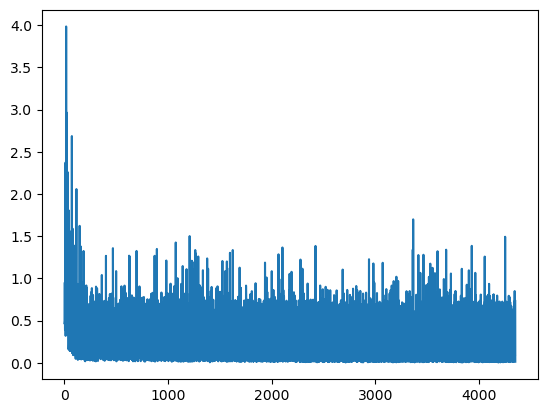

In [176]:
# want to see loss trending down
plt.plot(np.array(losses))

In [ ]:
# Next steps: 

# create delta for rest of input columns
# train test split 
# integrating all zipcodes - make dict of zipcodes and then handle zipcodes one by one